<a href="https://colab.research.google.com/github/CesarPortales/BootCamp/blob/master/Practica_final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Carga de Librerías y funciones útiles

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
ruta="/content/drive/My Drive/Proyecto final Keepcoding/data/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import math

# Función que calcula la distancia entre dos puntos
# Desde el módulo de arquitectura, he planteado que iba a hacer un trabajo sobre información turística.
# Para este ejercicio, se añadirá información sobre la distancia que hay a museos y transportes destacados
def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598 
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia


In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import seaborn as sns
from scipy import stats
from scipy.stats import norm


import warnings
warnings.filterwarnings('ignore')


In [0]:
#Cargamos el fichero de airbnb


ruta_datos_completo=ruta + "airbnb-listings-extract.csv"
df_Completo= pd.read_csv(ruta_datos_completo, sep=';', decimal='.')

df_Completo.shape

(14780, 89)

Desde el prinicipio del Máster se nos dijo que trabajásemos con datos referentes a Madrid. El dataset de airbnb viene muy sucio, con mucho ruido, y con datos de muy diferentes países.

Haciendo pruebas previas al ejercicio, si empezaba haciendo la división de los datos en train y test y después filtraba los datos de Madrid, había ocasiones en que se obtenían resultados muy desproporcionados al eliminar los datos sobrantes.

Por eso, y como esto no implica haber examinado los datos, he optado por filtrar los datos de España antes de hacer la división en train y test

Dado que (como se verá más adelante) al seleccionar los datos de Madrid hay que hacer una exploración profunda, y se podría producir algún sesgo en la investigación, este paso ya si que se dará con los datos divididos.

In [0]:
print("Las dimensiones del dataset son:", df_Completo.shape)
df_Madrid = df_Completo.drop(df_Completo[df_Completo.Country != "Spain"].index)
# Tras eliminar filas, hay que reconstruir el índice del dataset. en nuestro caso es imprescindible, 
# porque luego vamos a concatenar con otro dataset que debe tener los mismos índices.
# el argumento drop es para que no se genere una columna nueva con los valores del índice
df_Madrid.reset_index(drop=True, inplace=True)
print("Las dimensiones del dataset una vez seleccionados los datos de España son:", df_Madrid.shape)

Las dimensiones del dataset son: (14780, 89)
Las dimensiones del dataset una vez seleccionados los datos de España son: (14001, 89)


In [0]:
#Procedemos a hacer la división en train y en test
from sklearn.model_selection import train_test_split

train, test= train_test_split(df_Madrid, test_size = 0.2, random_state=0, shuffle=True)

print('Datos train: ', train.shape)
print('Datos test:  ', test.shape)

Datos train:  (11200, 89)
Datos test:   (2801, 89)


A partir de este momento, hasta finalizar el análisis de datos, trabajaremos solo sobre los datos de entrenamiento, y todas las operaciones que se realicen, se repetirán posteriormente sobrer los datos de test

In [0]:
#Guardaremos los datos de train y test en sus correspondiente ficheros csv.
#El motivo es que será más cómodo cargarlos cuando se neceisten e importarlos con estructura de dataframe de pandas
# con las ventajas que esto conlleva (que se ha perdido al hacer la división)
rutaTrain=ruta + 'train.csv'
rutaTest=ruta + 'test.csv'
train.to_csv(rutaTrain, sep=';', decimal='.', index=False)
test.to_csv(rutaTest, sep=';', decimal='.', index=False)

# 1.- Análisis de datos

##Carga de datos y exploración previa

Cargamos los datos de entrenamiento

In [0]:
df_train = pd.read_csv(rutaTrain, sep=';', decimal='.')

In [0]:
# Vamos a añadir columnas en las que calcularemos la distancia entre los alojamientos y diferentes puntos de interés turístico
# para ver si tienen influencia en el precio

#Calculamos distancias al "Paseo de los museos"

lat_museos = 40.4137859
lon_museos = -3.6943158

df_train['Dist_Museos']=df_train.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_museos,lon_museos),axis=1)

#Calculamos distancia al aeropuerto de Madrid-Barajs

lat_aeropuerto = 40.4983363
lon_aeropuerto = -3.5697869

df_train['Dist_Aeropuerto']=df_train.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_aeropuerto,lon_aeropuerto),axis=1)

# Calculamos distancia a la estación de Atocha

lat_atocha = 40.4063347
lon_atocha = -3.6922783

df_train['Dist_Atocha']=df_train.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_atocha,lon_atocha),axis=1)

# Calculamos distancia a la estación de Chamartín

lat_chamar = 40.4718949
lon_chamar = -3.6847452

df_train['Dist_Chamartin']=df_train.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_atocha,lon_atocha),axis=1)

#df_train['Ratio_Guest_price']=df_train.apply(lambda row:row.Price/row['Guests Included'], axis=1)
df_train['Ratio_Guest_Beds']=df_train.apply(lambda row:row['Guests Included']/row.Beds,axis=1)
df_train['Ratio_Guest_Rooms']=df_train.apply(lambda row:0 if row.Bedrooms == 0 else row['Guests Included']/row.Bedrooms,axis=1)
df_train.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11160,11161,11162,11163,11164,11165,11166,11167,11168,11169,11170,11171,11172,11173,11174,11175,11176,11177,11178,11179,11180,11181,11182,11183,11184,11185,11186,11187,11188,11189,11190,11191,11192,11193,11194,11195,11196,11197,11198,11199
ID,11638814,17914450,3771156,15525579,14929245,10939061,1061216,10490005,17933917,5791993,2731726,14374077,15975417,12999503,3762974,6308674,11050879,9069145,12383948,15593453,13385347,6336425,1717189,4018990,4573540,6478626,13663147,14704409,3173812,3811518,11774591,1755242,7907450,7230128,13993747,4799940,12914811,6641567,11312892,4692716,...,15652811,4791617,14033209,15446090,13790852,4786128,8064917,14243190,4969560,6615853,12878869,12402651,4330844,15245145,15458474,13795499,15253701,13196987,17505027,15741956,494434,16586287,17751153,14061933,15081897,8315255,5929004,1459831,15638219,7272682,14701802,6484871,15154841,14961893,16686992,13985137,12983112,13523658,5300343,12876691
Listing Url,https://www.airbnb.com/rooms/11638814,https://www.airbnb.com/rooms/17914450,https://www.airbnb.com/rooms/3771156,https://www.airbnb.com/rooms/15525579,https://www.airbnb.com/rooms/14929245,https://www.airbnb.com/rooms/10939061,https://www.airbnb.com/rooms/1061216,https://www.airbnb.com/rooms/10490005,https://www.airbnb.com/rooms/17933917,https://www.airbnb.com/rooms/5791993,https://www.airbnb.com/rooms/2731726,https://www.airbnb.com/rooms/14374077,https://www.airbnb.com/rooms/15975417,https://www.airbnb.com/rooms/12999503,https://www.airbnb.com/rooms/3762974,https://www.airbnb.com/rooms/6308674,https://www.airbnb.com/rooms/11050879,https://www.airbnb.com/rooms/9069145,https://www.airbnb.com/rooms/12383948,https://www.airbnb.com/rooms/15593453,https://www.airbnb.com/rooms/13385347,https://www.airbnb.com/rooms/6336425,https://www.airbnb.com/rooms/1717189,https://www.airbnb.com/rooms/4018990,https://www.airbnb.com/rooms/4573540,https://www.airbnb.com/rooms/6478626,https://www.airbnb.com/rooms/13663147,https://www.airbnb.com/rooms/14704409,https://www.airbnb.com/rooms/3173812,https://www.airbnb.com/rooms/3811518,https://www.airbnb.com/rooms/11774591,https://www.airbnb.com/rooms/1755242,https://www.airbnb.com/rooms/7907450,https://www.airbnb.com/rooms/7230128,https://www.airbnb.com/rooms/13993747,https://www.airbnb.com/rooms/4799940,https://www.airbnb.com/rooms/12914811,https://www.airbnb.com/rooms/6641567,https://www.airbnb.com/rooms/11312892,https://www.airbnb.com/rooms/4692716,...,https://www.airbnb.com/rooms/15652811,https://www.airbnb.com/rooms/4791617,https://www.airbnb.com/rooms/14033209,https://www.airbnb.com/rooms/15446090,https://www.airbnb.com/rooms/13790852,https://www.airbnb.com/rooms/4786128,https://www.airbnb.com/rooms/8064917,https://www.airbnb.com/rooms/14243190,https://www.airbnb.com/rooms/4969560,https://www.airbnb.com/rooms/6615853,https://www.airbnb.com/rooms/12878869,https://www.airbnb.com/rooms/12402651,https://www.airbnb.com/rooms/4330844,https://www.airbnb.com/rooms/15245145,https://www.airbnb.com/rooms/15458474,https://www.airbnb.com/rooms/13795499,https://www.airbnb.com/rooms/15253701,https://www.airbnb.com/rooms/13196987,https://www.airbnb.com/rooms/17505027,https://www.airbnb.com/rooms/15741956,https://www.airbnb.com/rooms/494434,https://www.airbnb.com/rooms/16586287,https://www.airbnb.com/rooms/17751153,https://www.airbnb.com/rooms/14061933,https://www.airbnb.com/rooms/15081897,https://www.airbnb.com/rooms/8315255,https://www.airbnb.com/rooms/5929004,https://www.airbnb.com/rooms/1459831,https://www.airbnb.com/rooms/15638219,https://www.airbnb.com/rooms/7272682,https://www.airbnb.com/rooms/14701802,https://www.airbnb.com/rooms/6484871,https://www.airbnb.com/rooms/15154841,https://www.airbnb.com/rooms/14961893,https://www.airbnb.com/rooms/16686992,https://www.airbnb.com/rooms/13985137,https://www.airbnb.com/rooms/12983112,https://www.airbnb.com/rooms/13523658,https

In [0]:
#Cambiamos la configuración de pandas para que cuando ejecutemos instrucciones que muestren "listados largos" se muestre el resultado completo
pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

#Visualizamos los campos disponibles con sus correspondientes tipos de datos
df_train.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

 Por aligerar el dataset, empezaremos filtrando solo los datos de Madrid.
 En principio se podrían usar campos como  'Zip Code' o 'City', pero se observa que el que tiene menos ruido es el campo 'Smart Location'

In [0]:
lista_madrid =df_train['Smart Location'].unique().tolist()
print("Datos encontrados en el campo 'Smart Location:'", lista_madrid)
print("Datos antes de filtrar:", df_train.shape)
#Creamos una lista con los valores que se hacen referencia a la ciudad de Madrid
lista_madrid_0= ['Madrid, Spain','Madrid, Comunidad de Madrid, ES, Spain','Madrid , Spain','Madri, Spain','Delicias-Madrid, Spain','madrid, Spain',
                 'Madrid, Comunidad de Madrid, ESPANA, Spain','Madid, Spain','La Elipa, Spain','Comunidad de Madrid, Spain','Aravaca (Madrid), Spain','Ventas, Spain','Chueca, Spain',
                 'Chueca, Madrid, Spain','Delicias, Spain','Madrid, Vallecas (Fontarrón), Spain', 'MADRID, Spain','Centro, Spain','Centro, Madrid, Spain', 'MADRID , Spain', 
                 'villa verde bajo, Spain','Aravaca , Spain']
# Nos quedamos solo con los elementos incluidos en la lista de valores que implican pertencer a Madrid

df_train= df_train[df_train['Smart Location'].isin(lista_madrid_0)]
# Tras eliminar filas, hay que reconstruir el índice del dataset. en nuestro caso es imprescindible, 
# porque luego vamos a concatenar con otro dataset que debe tener los mismos índices.
# el argumento drop es para que no se genere una columna nueva con los valores del índice
df_train.reset_index(drop=True, inplace=True)
print("Datos después de filtrar:", df_train.shape)

Datos encontrados en el campo 'Smart Location:' ['Madrid, Spain', 'Barcelona, Spain', 'Madrid, Comunidad de Madrid, ES, Spain', 'Madrid, Comunidad de Madrid, ESPANA, Spain', 'Algaida, Spain', '马德里, Spain', 'Alcúdia, Spain', 'Son Vida, Spain', 'Sant Joan, Spain', 'Santa Margalida, Spain', 'Selva, Spain', 'Alaró, Spain', 'Palma de Mallorca , Spain', 'Santa Margalida , Spain', 'Can Pastilla, Spain', 'La Puebla, Spain', 'Pollença, Spain', 'Muro (Mallorca), Spain', 'Betlem, Spain', 'Sóller, Spain', 'Búger, Spain', 'Valldemossa, Spain', 'Manacor, Spain', 'Costitx, Spain', 'Pollensa, Spain', 'Binissalem, Spain', 'Madrid, Vallecas (Fontarrón), Spain', 'Son Veri Nou , Llucmajor , Spain', 'Ariany, Spain', 'Petra, Spain', 'Inca, Spain', 'Palma, Spain', 'Madrid , Spain', 'Alcudia, Spain', 'Deià, Spain', 'Pozuelo, Spain', 'Campos, Spain', 'Provensals, Spain', 'Aravaca (Madrid), Spain', 'Cala Santanyí, Spain', 'Rotes Velles, Spain', 'Centro, Spain', 'Muro, Spain', 'Santa Ponsa, Spain', 'Palma de Mal

In [0]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Pasamos a analizar las columnas del dataset para ver si podemos eliminar alguna

In [0]:
# Todas las columnas con el sufijo Url exceden el objeto de análisis de este estudio
columns_to_drop = [
    'Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 'Host Thumbnail Url', 'Host Picture Url']

# Los identificadores del alojamiento no van a influir de ninguna manera en el precio
columns_to_drop.extend(['ID','Host ID','Name','Host Name'])

# La información sobre Host en general presentan mucho ruido, muchos valores nulos, y no hacen referencia al alojamiento
columns_to_drop.extend(['Host Response Time','Host Response Rate','Host Acceptance Rate','Host Verifications','Host Neighbourhood',
                        'Calculated host listings count','Host Listings Count', 'Host Total Listings Count','Host Location','Host About','Interaction' ])

# Los siguientes campos contienen información descriptiva que se puede obtener con menos esfuerzo a partir de otros campos.
# Datos como Summary, Space, Description requerirían mucho esfuerzo de procesamiento, 
# cuando la información útil que podrían proporcionar (como el tipo de alojamiento, camas, tamaño) se puede obtener con menor costo computacional de otros campos.
# Además, obtener este tipo de información generaría muchos valores Nan (no todos los alojamientos proporcionan la misma información en estos campos)
# y los resultados estarían muy correlados con otros campos.
# Lo mismo se podría decir de 'House Rules', 'Features' o 'Access'. Gran parte de la información útil (si se puede o no fumar, si admiten mascotas, etc.) se puede obtener
# por ejemplo de 'Amenities'. Igual ocurre con Transit o Access: la información de acceso (si hay o no portero, si hay o no ascensor, etc.)
# también se puede obtener con más facilidad de otros campos. Y la cercanía a Metros, autobuses o monumentos la cubriremos con la información de Geolocalización
columns_to_drop.extend(['Summary','Space','Description','Notes','Transit','Access','House Rules','Features'])

# La mayoría de los campos siguientes incluyen demasiado ruido y valores Nan. Los que no (como Country, city o Zipcode) no son necesarios puesto que solo vamos a trabajar
# con datos de Madrid . La calle (mucho ruido) y la Geolocalización no serían necesarios, puesto que vamos a usar la longitud y la latitud.
columns_to_drop.extend(['Neighborhood Overview', 'Street', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'City','Zipcode','Geolocation' ])

# Presentan mucho ruido, y estarán demasiado correlados con el precio
columns_to_drop.extend(['Weekly Price','Monthly Price'])

#Los datos sobre fechas de actualización, revisión, etc. no afectarán al alojamiento (más cuando no se registran periodos de tiempo y todos ellos tienen fechas parecidas)
columns_to_drop.extend(['Scrape ID','Last Scraped','Calendar last Scraped','Calendar Updated','First Review','Last Review'])


In [0]:
# El campo "Experiences Offered" podría resultar interesante, pero no tiene datos para Madrid, así que lo eliminaremos
print('El contenido del campo "Experiences Offered" es: ', df_train['Experiences Offered'].value_counts())


El contenido del campo "Experiences Offered" es:  none    10598
Name: Experiences Offered, dtype: int64


In [0]:
columns_to_drop.extend(['Experiences Offered'])
df_train.drop(columns_to_drop,axis=1,inplace=True)

# 1.2 Análisis de datos: La variable objetivo

Vamos a analizar nuestra variable objetivo ('Price') y a comprobar si tiene outliers. Lo comprobamos mediante un boxplot

count    10591.000000
mean        65.485129
std         55.854434
min          9.000000
25%         30.000000
50%         52.000000
75%         80.000000
max        875.000000
Name: Price, dtype: float64


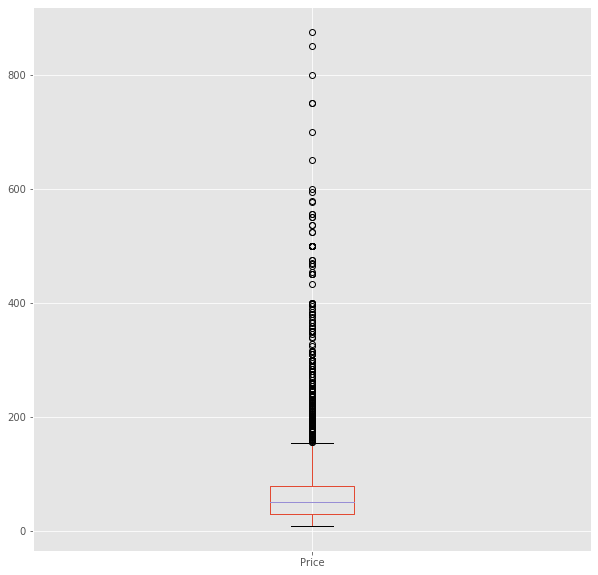

In [0]:
print(df_train['Price'].describe())
df_train.plot(kind='box',y='Price',grid=True,figsize=(10 ,10))

plt.show()

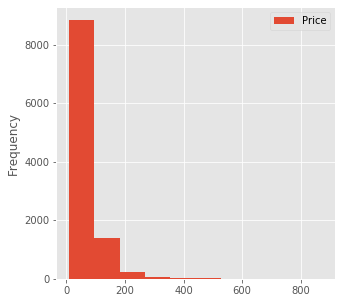

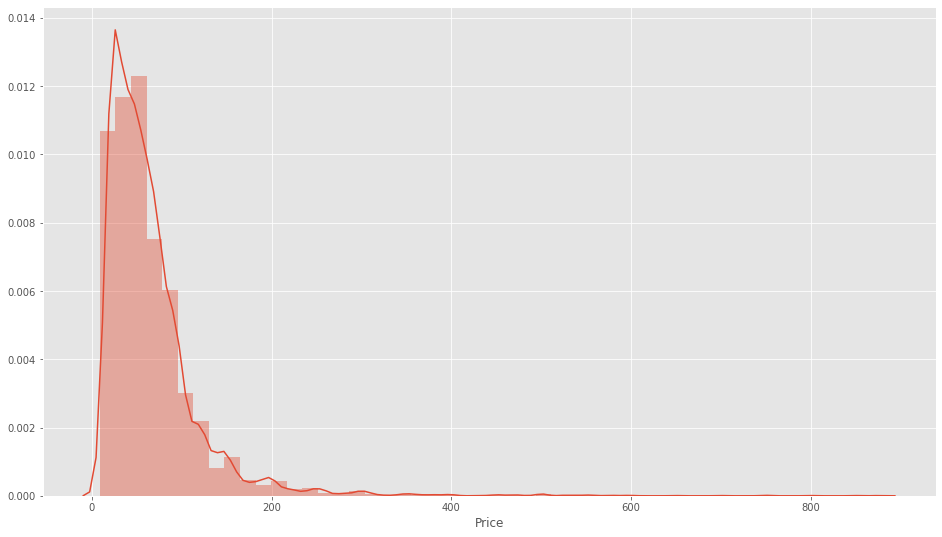

In [0]:
# Podemos también verlo en un histograma
df_train.plot(kind='hist',y='Price',grid=True,figsize=(5 ,5))

plt.show()
sns.distplot(df_train['Price']);

A simple vista se ve que hay desviación típica respecto a la distribución normal, una simetría positiva y se observa la presencia de algunos picos

Vemos que se consideran outliers aproximadamente a partir de 180. Pero se ve que hasta aproximadamente el 250 hay un grupo grande de valores.

Comprobamos cuantos valores hay por encima de 250 de precio

In [0]:
# Por probar, usamos otra posible forma de filtrar. Usaremos el método query de pandas
len(df_train.query('Price > 250')['Price'])

134

134 es un número razonable de registros para eliminar

In [0]:
df_train=df_train[df_train['Price']<=250]
print("Número de registros tras eliminar los precios superiores a 250:",df_train.shape)

Número de registros tras eliminar los precios superiores a 250: (10457, 45)


In [0]:
# Aunque se veía claro en los gráficos, nos aseguramos de que no haya precios iguales a cero
print(f"Registros con precio cero: {len(df_train[df_train['Price'] == 0])}")

Registros con precio cero: 0


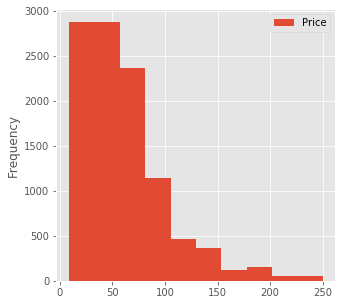

In [0]:
df_train.plot(kind='hist',y='Price',grid=True,figsize=(5 ,5))

plt.show()

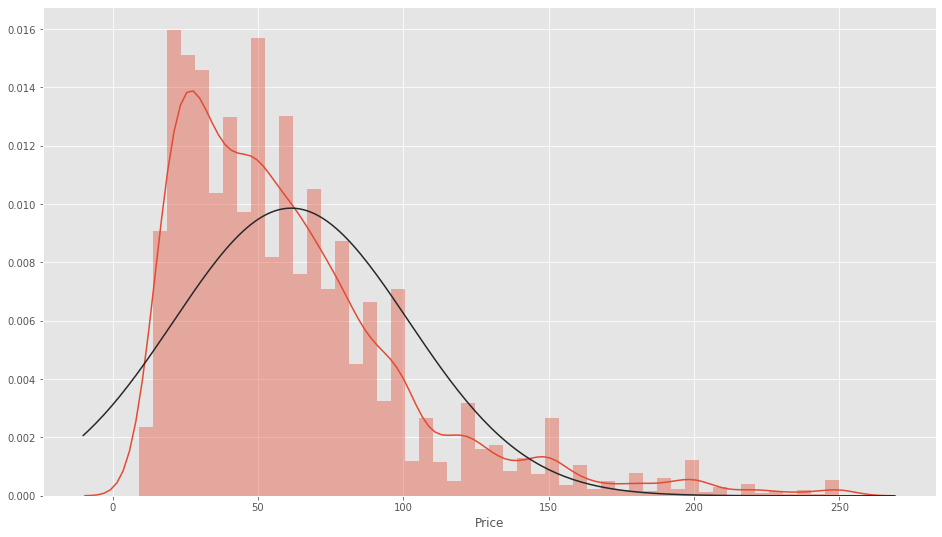

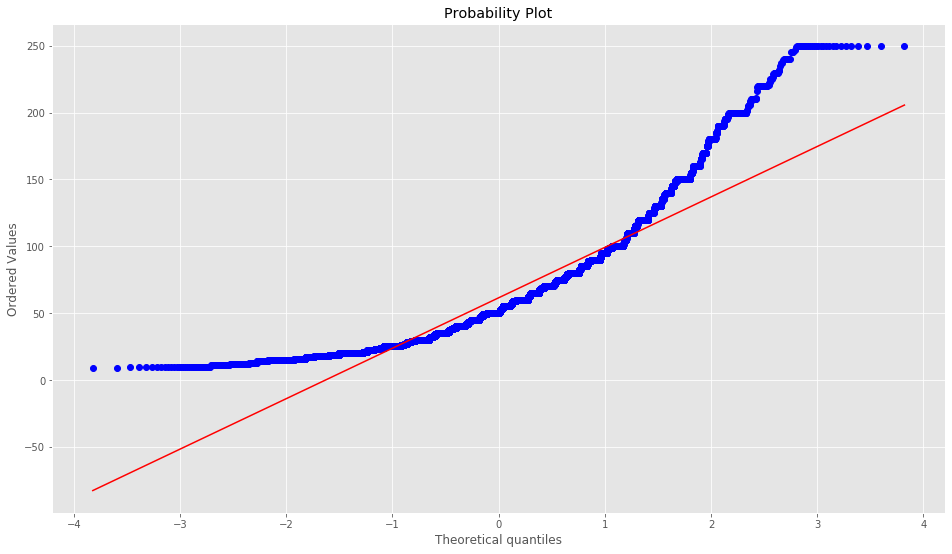

In [0]:
# Histograma y gráfico de probabilidad normal:

sns.distplot(df_train['Price'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train['Price'], plot = plt)

De estos gráficos se desprende que 'Price' no conforma una distribución normal. Muestra picos, asimetría positiva y no sigue la línea diagonal; aunque una simple transformación de datos puede resolver el problema.

In [0]:
# Transformación de los datos:

df_train['Price'] = np.log(df_train['Price'])

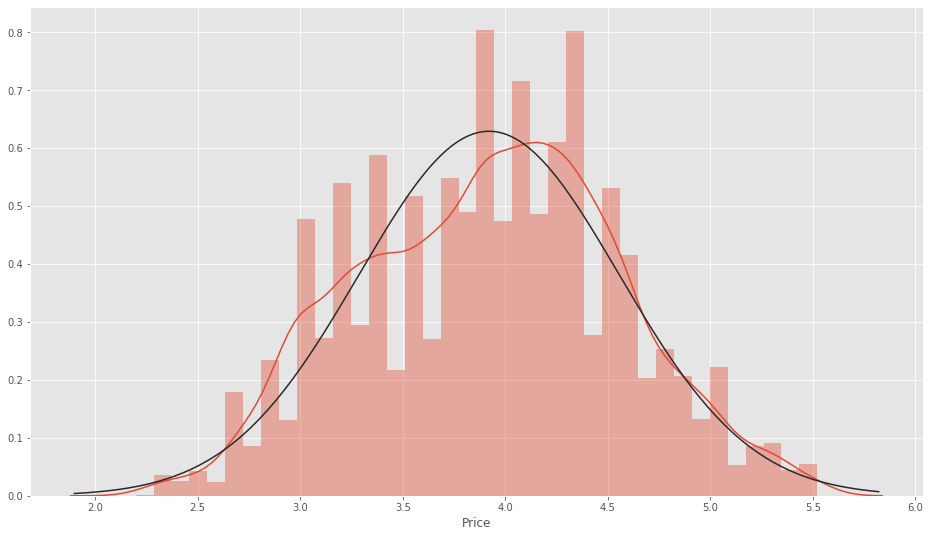

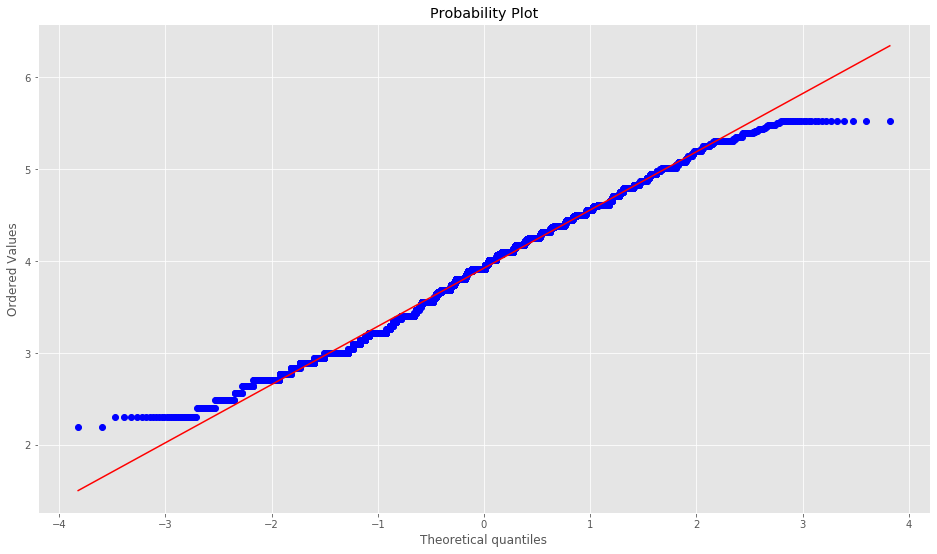

In [0]:
# Histograma y gráfico de probabilidad normal:

sns.distplot(df_train['Price'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train['Price'], plot = plt)

# 1.1 Análisis de datos: Correlaciones

Hacemos análisis de correlaciones

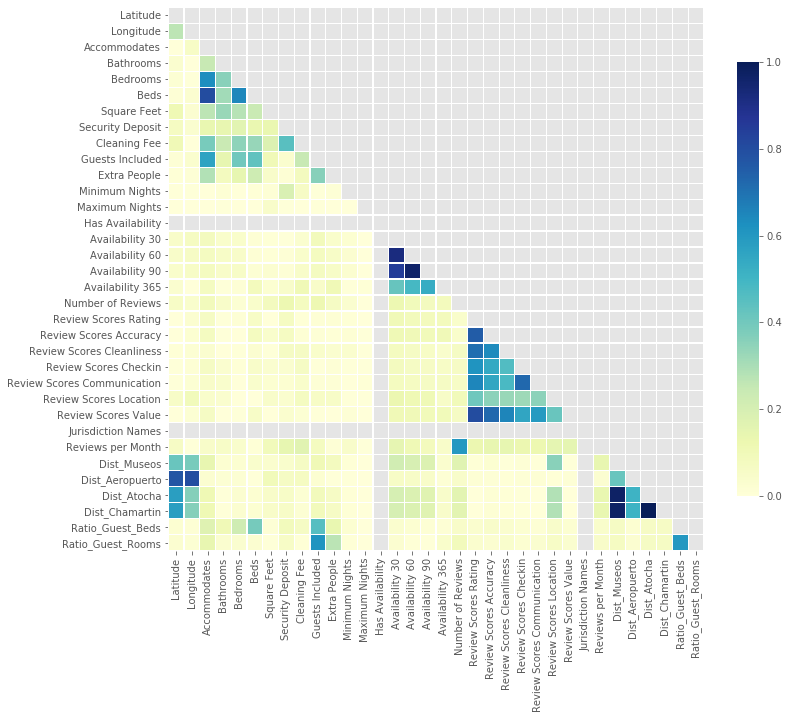

In [0]:

# Compute the correlation matrix
#corr = np.abs(df_train.drop(['Price'], axis=1).corr())
corr = np.abs(df_train.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos que 'Accomodates' está muy correlacionada con 'Beds', así que la eliminaremos. Los diferentes 'Availability' también lo están, así que los eliminaremos salvo el 'Avalilability 365'. 

La distancia entre los museos y Atocha y Chamartín tiene también fuerte correlación, así que la única distancia que dejaremos será la distancia a los museos.

Beds y Bedrooms, como sería de esperar, también están muy correlacionadas, aunque no lo suficiente como para eliminarlas

Has Availability y Jurisciction Names tienen aspecto de no contener valores. Examinaremos más adelante al ver los missings.

In [0]:
df_train.drop(['Accommodates','Availability 30', 'Availability 60', 'Availability 90','Dist_Atocha','Dist_Chamartin'], axis=1, inplace=True)

Los Review Scores están al límite, pero vamos a esperar a hacer análisis de Missings

In [0]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr[['Review Scores Rating']].sort_values(by = 'Review Scores Rating',ascending = False)


,Review Scores Rating
Review Scores Rating,1.000000
Review Scores Value,0.802057
Review Scores Accuracy,0.754641
Review Scores Cleanliness,0.708703
Review Scores Communication,0.649223
Review Scores Checkin,0.617064
Review Scores Location,0.407206
Reviews per Month,0.130404
Security Deposit,0.071180
Price,0.061969


Volvemos a generar la matriz de correlaciones, obteniendo mejores resultados

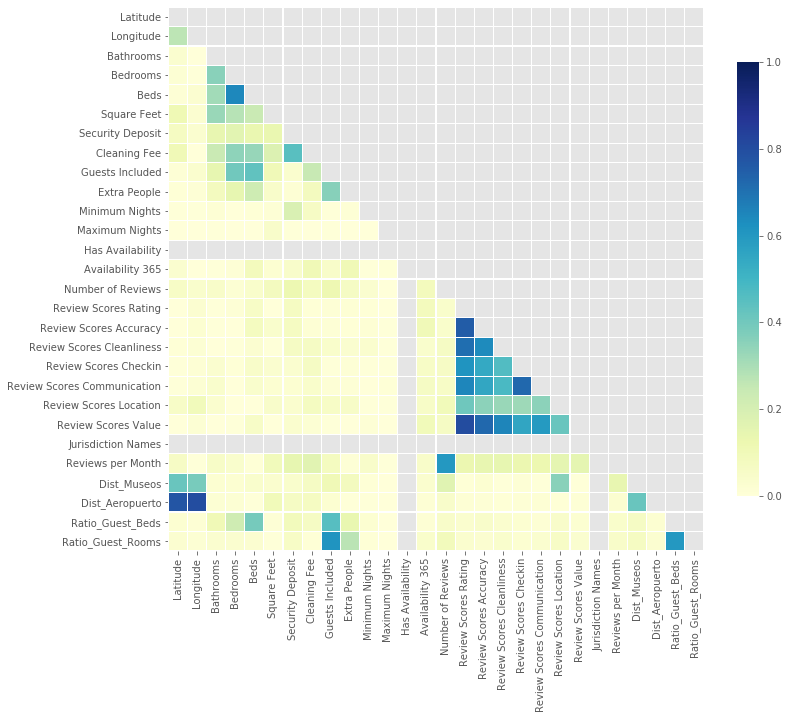

In [0]:

# Compute the correlation matrix
corr = np.abs(df_train.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

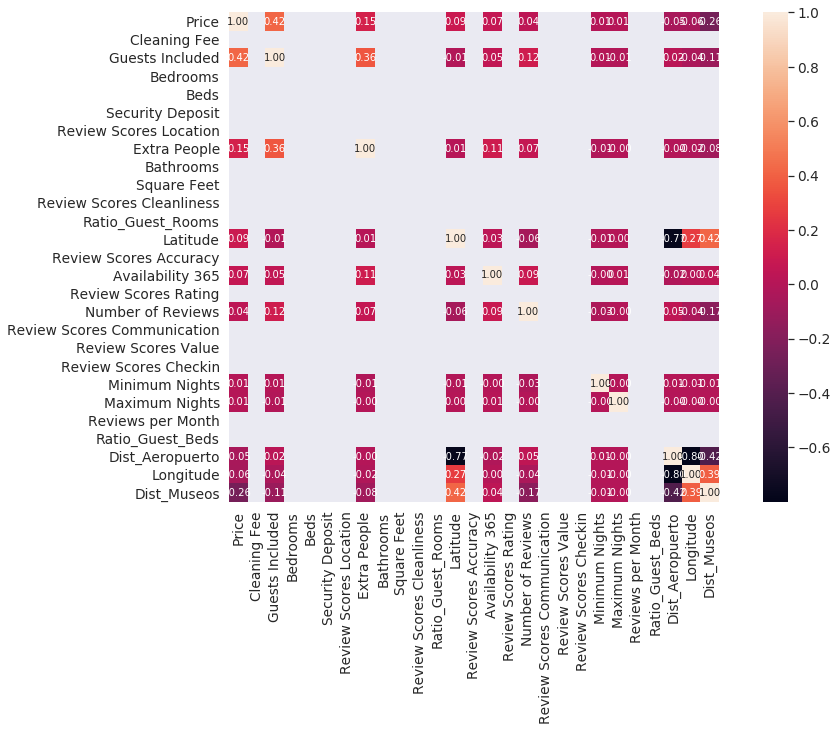

In [0]:
# Matriz de correlación
k = 35 # Número de variables.
corrmat = df_train.corr()
cols = corrmat.nlargest(k,'Price')['Price'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = cols.values, xticklabels = cols.values)
plt.show()

In [0]:
corr = df_train.corr()
corr[['Price']].sort_values(by = 'Price',ascending = False)\
.style.background_gradient()

,Price
Price,1
Cleaning Fee,0.587259
Guests Included,0.422899
Bedrooms,0.420783
Beds,0.418162
Security Deposit,0.283797
Review Scores Location,0.208096
Extra People,0.147468
Bathrooms,0.14404
Square Feet,0.130734


In [0]:
# Hacemos un scatter_plot para hacernos una idea de cómo se relacionan las variables que quedan
#pd.plotting.scatter_matrix(df_train, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
#plt.show()

# Análisis de NaN

In [0]:
# Vamos a ver cuantos NAN hay en cada columna para eliminar las columnas en los que sean excesivos
# Para eso, nos aprovechamos de que la función count ignora los NaN
len(df_train) - df_train.count() 

Host Since                          2
Neighbourhood                    3537
Neighbourhood Cleansed              0
Neighbourhood Group Cleansed        0
Latitude                            0
Longitude                           0
Property Type                       0
Room Type                           0
Bathrooms                          40
Bedrooms                           21
Beds                               40
Bed Type                            0
Amenities                          81
Square Feet                     10059
Price                               0
Security Deposit                 6041
Cleaning Fee                     4338
Guests Included                     0
Extra People                        0
Minimum Nights                      0
Maximum Nights                      0
Has Availability                10457
Availability 365                    0
Number of Reviews                   0
Review Scores Rating             2255
Review Scores Accuracy           2268
Review Score

In [0]:
#Añadimos a la lista de columnas que liminar las que tienen más de un diez por ciento de NaN
columns_to_drop=['Neighbourhood','Square Feet', 'Has Availability','Security Deposit',
                        'Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
                        'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value','License','Reviews per Month', 'Jurisdiction Names']
print("Las columnas del dataset que se eliminarán son:",columns_to_drop)

#Un caso particular es el campo 'Cleaning Fee'. Tiene un número elevadísimo de NaN's (4383 sobre un total de 1059)
# Entiendo que puede influir mucho más que otros campos, así que, en principio, no se va a eliminar.
# Para que no se me olvide, , lo voy a dejar relleno. En lugar de rellenarlo con la mediana o la moda, vamos a sustituir los NaN por ceros.
# ¿Motivo?. Si miramos en la página de airbnb, hay muy pocos alojamientos que incluyan este concepto, con lo que vamos a interpretar en principio que 
# los alojamientos que carecen de este valor, es porque no lo contemplan o porque no cobran por esto
df_train['Cleaning Fee'].fillna(0., inplace=True)

#Eliminamos las columnas seleccionadas para tal efecto
df_train.drop(columns_to_drop, axis=1, inplace=True)
print ("Dimensiones del dataset tras eliminar columnas:",df_train.shape)

df_train.head().T

Las columnas del dataset que se eliminarán son: ['Neighbourhood', 'Square Feet', 'Has Availability', 'Security Deposit', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'License', 'Reviews per Month', 'Jurisdiction Names']
Dimensiones del dataset tras eliminar columnas: (10457, 25)


,0,1,2,3,4
Host Since,2015-09-11,2011-07-17,2014-05-16,2016-07-11,2012-07-31
Neighbourhood Cleansed,Justicia,Embajadores,Pueblo Nuevo,Prosperidad,Almagro
Neighbourhood Group Cleansed,Centro,Centro,Ciudad Lineal,Chamartín,Chamberí
Latitude,40.421,40.4078,40.4274,40.4393,40.4354
Longitude,-3.69743,-3.70321,-3.63376,-3.6749,-3.69778
Property Type,Apartment,Apartment,Apartment,Apartment,Apartment
Room Type,Private room,Private room,Private room,Private room,Entire home/apt
Bathrooms,1,1,1,2,1
Bedrooms,1,3,1,1,1
Beds,1,3,1,2,2



# Datos categóricos

In [0]:
df_train.select_dtypes(include=['object']).columns

Index(['Host Since', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
       'Property Type', 'Room Type', 'Bed Type', 'Amenities',
       'Cancellation Policy'],
      dtype='object')

### Trabajo con Amenities

El campo 'Amenities' sí que tiene información que puede ser importante, y que estudiaremos con técnicas básicas de NLP. 

No se requerirá un estudio muy avanzado porque como veremos a continuación, la información es muy poco variada (tiene aspecto de haberse seleccionado desde algún tipo de menú). Así que en principio usaremos 'Feature_extraction' de sklearn, que es eficaz y sencillo de manejar.

Crearemos una columna en el dataset por cada uno de los valores del campo, y luego nos quedaremos solo con las columnas que nos interesen

In [0]:
# Cargamos librería necesaria
import string

# Establecemos el listado de caracteres de puntuación que no se analizarán
punctuation = set(string.punctuation)

# Definimos una función para 'tokenizar'. Los valores que queremos extraer vienen separados por comas, 
# así que vamos a establecer este carácter como separador.
# Por pura estética cambiaremos los texto a capital en lugar de a minúscula (valor por defecto de CountVectorizer)
# Como los datos son tan homogéneos, veremos que no hace falta controlar más (tildes, etc.)

def tokenize(sentence):
    tokens = []
    for token in sentence.split(','):
        new_token = []
        for character in token:
            if character not in punctuation:
                new_token.append(character.capitalize())
        if new_token:
            tokens.append("".join(new_token))
    return tokens

In [0]:
# feature_extracton da error si encuentra valores Nan, así que rellenaremos con un valor cualquiera (por ejemplo, 'Z')
# Luego borraremos la columna nueva que se va a generar, así que da igual qué valor se ponga
df_train['Amenities'].fillna('Z',inplace= True)

In [0]:
# Cargamos CountVectorizer, que realizará todo el proceso de extracción de datos y creará un campo nuevo en el dataset por cada valor que encuentre
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# Configuramos CountVectporizer con los parámetros de la función tokenize que hemos creado
amenities_vectorizer = CountVectorizer(
    tokenizer = tokenize,
    binary=True # Solo creará valores uno o cero en lugar de contabilizar todas las repeticiones
)

In [0]:
# Hacemos el fit
amenities_vectorizer.fit(df_train['Amenities'])

# imprescindible el toarray() para que los datos se incluyan en un array y sean manejables
vectors = amenities_vectorizer.transform(df_train['Amenities']).toarray()

In [0]:
print(f'Se han generado un total de {vectors.shape[1]} campos.')

Se han generado un total de 68 campos.


In [0]:
# Visualizamos las columnas generadas y creamos un dataframe que guarde los resultados
# El dataframe que se genera mantiene las filas en el mismo orden, pero guarda los campos ordenados alfabéticamente
# Por eso es imprescindible usar 'sorted'
headers = sorted(amenities_vectorizer.vocabulary_.keys())

print("Columnas generadas a partir de los valores de 'Amenities' \n")
print(np.transpose(headers))

# Guardamos cabeceras y datos en un dataframe
df_am=pd.DataFrame(vectors, columns=headers)
print(f"\nSe ha generado un dataset de {df_am.shape[0]} filas y {df_am.shape[1]} columnas.\n")
df_am.head(10)

Columnas generadas a partir de los valores de 'Amenities' 

['24HOUR CHECKIN' 'AIR CONDITIONING' 'BABY BATH'
 'BABYSITTER RECOMMENDATIONS' 'BATHTUB' 'BREAKFAST'
 'BUZZERWIRELESS INTERCOM' 'CABLE TV' 'CARBON MONOXIDE DETECTOR' 'CATS'
 'CHANGING TABLE' 'CHILDREN’S BOOKS AND TOYS' 'CHILDREN’S DINNERWARE'
 'CRIB' 'DOGS' 'DOORMAN' 'DOORMAN ENTRY' 'DRYER' 'ELEVATOR IN BUILDING'
 'ESSENTIALS' 'FAMILYKID FRIENDLY' 'FIRE EXTINGUISHER' 'FIRST AID KIT'
 'FREE PARKING ON PREMISES' 'FREE PARKING ON STREET' 'GAME CONSOLE' 'GYM'
 'HAIR DRYER' 'HANGERS' 'HEATING' 'HIGH CHAIR' 'HOT TUB'
 'INDOOR FIREPLACE' 'INTERNET' 'IRON' 'KEYPAD' 'KITCHEN'
 'LAPTOP FRIENDLY WORKSPACE' 'LOCK ON BEDROOM DOOR' 'LOCKBOX' 'OTHER PETS'
 'OUTLET COVERS' 'PACK ’N PLAYTRAVEL CRIB' 'PAID PARKING OFF PREMISES'
 'PETS ALLOWED' 'PETS LIVE ON THIS PROPERTY' 'POOL' 'PRIVATE ENTRANCE'
 'PRIVATE LIVING ROOM' 'ROOMDARKENING SHADES' 'SAFETY CARD' 'SELF CHECKIN'
 'SHAMPOO' 'SMARTLOCK' 'SMOKE DETECTOR' 'SMOKING ALLOWED' 'STAIR GATES'
 '

,24HOUR CHECKIN,AIR CONDITIONING,BABY BATH,BABYSITTER RECOMMENDATIONS,BATHTUB,BREAKFAST,BUZZERWIRELESS INTERCOM,CABLE TV,CARBON MONOXIDE DETECTOR,CATS,CHANGING TABLE,CHILDREN’S BOOKS AND TOYS,CHILDREN’S DINNERWARE,CRIB,DOGS,DOORMAN,DOORMAN ENTRY,DRYER,ELEVATOR IN BUILDING,ESSENTIALS,FAMILYKID FRIENDLY,FIRE EXTINGUISHER,FIRST AID KIT,FREE PARKING ON PREMISES,FREE PARKING ON STREET,GAME CONSOLE,GYM,HAIR DRYER,HANGERS,HEATING,HIGH CHAIR,HOT TUB,INDOOR FIREPLACE,INTERNET,IRON,KEYPAD,KITCHEN,LAPTOP FRIENDLY WORKSPACE,LOCK ON BEDROOM DOOR,LOCKBOX,OTHER PETS,OUTLET COVERS,PACK ’N PLAYTRAVEL CRIB,PAID PARKING OFF PREMISES,PETS ALLOWED,PETS LIVE ON THIS PROPERTY,POOL,PRIVATE ENTRANCE,PRIVATE LIVING ROOM,ROOMDARKENING SHADES,SAFETY CARD,SELF CHECKIN,SHAMPOO,SMARTLOCK,SMOKE DETECTOR,SMOKING ALLOWED,STAIR GATES,SUITABLE FOR EVENTS,TABLE CORNER GUARDS,TRANSLATION MISSING ENHOSTINGAMENITY49,TRANSLATION MISSING ENHOSTINGAMENITY50,TV,WASHER,WASHER DRYER,WHEELCHAIR ACCESSIBLE,WINDOW GUARDS,WIRELESS INTERNET,Z
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
3,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,1,0
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
7,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0
9,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0


In [0]:

df_am['Pets'] =(df_am['CATS'].astype(bool)) | (df_am['DOGS'].astype(bool)) | (df_am['OTHER PETS'].astype(bool)) | (df_am['PETS ALLOWED'].astype(bool)) |(df_am['PETS LIVE ON THIS PROPERTY'].astype(bool)) 
df_am_to_drop =['CATS','DOGS','OTHER PETS','PETS ALLOWED','PETS LIVE ON THIS PROPERTY']
df_am['InternetAccess'] =(df_am['INTERNET'].astype(bool)) | (df_am['WIRELESS INTERNET'].astype(bool)) 
df_am_to_drop.extend(['INTERNET','WIRELESS INTERNET'])
df_am['TempControl'] = (df_am['AIR CONDITIONING'].astype(bool)) | (df_am['HEATING'].astype(bool))
df_am_to_drop.extend(['AIR CONDITIONING','HEATING'])
df_am['KidsFriendly'] = (df_am['BABY BATH'].astype(bool)) | (df_am['BABYSITTER RECOMMENDATIONS'].astype(bool)) | (df_am['CHANGING TABLE'].astype(bool)) | (df_am['CHILDREN’S BOOKS AND TOYS'].astype(bool)) |(df_am['CHILDREN’S DINNERWARE'].astype(bool)) | (df_am['FAMILYKID FRIENDLY'].astype(bool)) | (df_am['CRIB'].astype(bool)) | (df_am['HIGH CHAIR'].astype(bool)) | (df_am['TABLE CORNER GUARDS'].astype(bool))  
df_am_to_drop.extend(['BABY BATH','BABYSITTER RECOMMENDATIONS','CHANGING TABLE','CRIB','CHILDREN’S BOOKS AND TOYS','CHILDREN’S DINNERWARE','FAMILYKID FRIENDLY'])
df_am_to_drop.extend(['24HOUR CHECKIN', 'BATHTUB', 'BREAKFAST','BUZZERWIRELESS INTERCOM', 'CABLE TV', 'CARBON MONOXIDE DETECTOR'])
df_am_to_drop.extend(['DOORMAN', 'DOORMAN ENTRY', 'DRYER', 'ELEVATOR IN BUILDING', 'FIRE EXTINGUISHER','FIRST AID KIT'])
df_am_to_drop.extend([ 'FREE PARKING ON PREMISES', 'FREE PARKING ON STREET', 'GAME CONSOLE', 'GYM','HIGH CHAIR'])
df_am_to_drop.extend(['HAIR DRYER', 'HANGERS', 'HOT TUB', 'INDOOR FIREPLACE', 'IRON' ,'KEYPAD'])
df_am_to_drop.extend([ 'LAPTOP FRIENDLY WORKSPACE', 'LOCK ON BEDROOM DOOR','LOCKBOX', 'OUTLET COVERS', 'PACK ’N PLAYTRAVEL CRIB'])
df_am_to_drop.extend([ 'PAID PARKING OFF PREMISES', 'PETS ALLOWED', 'PETS LIVE ON THIS PROPERTY', 'POOL', 'PRIVATE ENTRANCE'])
df_am_to_drop.extend(['PRIVATE LIVING ROOM', 'ROOMDARKENING SHADES' ,'SAFETY CARD', 'SELF CHECKIN'])
df_am_to_drop.extend(['SHAMPOO', 'SMARTLOCK', 'SMOKE DETECTOR' ,'STAIR GATES', 'SUITABLE FOR EVENTS','TABLE CORNER GUARDS'])
df_am_to_drop.extend([ 'TRANSLATION MISSING ENHOSTINGAMENITY49', 'TRANSLATION MISSING ENHOSTINGAMENITY50'])
df_am_to_drop.extend(['TV' ,'WASHER' ,'WASHER  DRYER', 'WINDOW GUARDS' , 'Z'])

In [0]:
df_am['Pets'] = df_am['Pets'].apply(lambda x: 1 if(x==True) else 0)
df_am['InternetAccess'] = df_am['InternetAccess'].apply(lambda x: 1 if(x==True) else 0)
df_am['TempControl'] = df_am['TempControl'].apply(lambda x: 1 if(x==True) else 0)
df_am['KidsFriendly'] = df_am['KidsFriendly'].apply(lambda x: 1 if(x==True) else 0)

In [0]:
df_am.drop(df_am_to_drop,axis=1,inplace=True)

In [0]:
df_am.shape

(10457, 8)

In [0]:
df_am.head()

,ESSENTIALS,KITCHEN,SMOKING ALLOWED,WHEELCHAIR ACCESSIBLE,Pets,InternetAccess,TempControl,KidsFriendly
0,1,1,0,0,1,1,1,1
1,1,1,1,0,0,1,1,0
2,1,1,0,0,0,1,1,0
3,1,0,0,0,0,1,1,1
4,0,1,0,0,0,1,1,1


In [0]:
df_am.isnull().any()

ESSENTIALS               False
KITCHEN                  False
SMOKING ALLOWED          False
WHEELCHAIR ACCESSIBLE    False
Pets                     False
InternetAccess           False
TempControl              False
KidsFriendly             False
dtype: bool

In [0]:
# Nos aseguramos de que los dos dataframes tienen el mismo número de filas
df_train.reset_index(drop=True, inplace=True)
print(f"El número de filas del dataset principal es {df_train.shape[0]}")
print(f"El número de filas del dataset de amenities es {df_am.shape[0]}")
print(f"Los valores del índice principal son: \n{df_train.index}")
print(f"Los valores del índice de amenities son:\n {df_am.index}")

El número de filas del dataset principal es 10457
El número de filas del dataset de amenities es 10457
Los valores del índice principal son: 
RangeIndex(start=0, stop=10457, step=1)
Los valores del índice de amenities son:
 RangeIndex(start=0, stop=10457, step=1)


In [0]:
# Unimos los campos al dataset
df_train = pd.concat([df_train,df_am],axis = 1)
print(f"El número de filas del dataset principal es {df_train.shape[0]}")
#Eliminamos el campo 'Amenities', puesto que ya hemos extraído los datos que nos interesan
columns_to_drop.extend(['Amenities'])
df_train.drop(['Amenities'],axis=1,inplace=True)

El número de filas del dataset principal es 10457


In [0]:
#Comprobamos que 'Host Since tiene dos valores en blanco. Los eliminaremos'
len(df_train) -df_train['Host Since'].count()

2

In [0]:
# Además de eliminar los NaN, este campo tiene fechas completas.
# Vamos a sustituirlas por los años de diferencia respecto al año 2017 (que esa el año de los datos del dataset)
#Crearemos la columna 'Years Host'
from datetime import datetime

df_train['Host Since'].dropna(inplace=True) 
df_train['Host Since'] = df_train['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df_train['Years Host'] = df_train['Host Since'].apply(lambda x: 2017 - x.year)
df_train['Years Host'].dropna(inplace=True) 
df_train.drop(['Host Since'], axis=1, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [0]:
print(df_train.shape)
df_train.dropna(inplace=True)
df_train.reset_index(drop=True, inplace=True)
print(df_train.shape)
len(df_train) -df_train['Years Host'].count()

(10457, 32)
(10384, 32)


0

Respecto a los Neighbourhood, podríamos usar cualquiera de los dos campos con el sufijo Cleansed. Usaremos el 'Neighbourhood Group Cleansed', que ya hemos visto que no tiene valores vacíos, y que agrupa la  información (por ejemplo en Centro incluye Embajadores, Palacio, Sol, etc.). Así que el campo  'Neighbourhood Cleansed' se puede eliminar.

In [0]:
df_train.drop(['Neighbourhood Cleansed'],axis=1,inplace=True)


In [0]:
df_train['Room Type'].value_counts()

Entire home/apt    6148
Private room       4086
Shared room         150
Name: Room Type, dtype: int64

In [0]:
df_train['Room Type']= df_train['Room Type'].apply(lambda row:4 if(row =='Entire home/apt')else 3 if(row =='Private room') else 1 )

In [0]:
df_train['Room Type'].value_counts()

4    6148
3    4086
1     150
Name: Room Type, dtype: int64

In [0]:
df_train['Bed Type'].value_counts()

Real Bed         10150
Pull-out Sofa      189
Futon               29
Couch               13
Airbed               3
Name: Bed Type, dtype: int64

In [0]:
df_train['Bed Type']= df_train['Bed Type'].apply(lambda row:5 if(row =='Real Bed') else 4 if(row =='Pull-out Sofa') else 3 if(row =='Futon') else 2 if(row =='Couch') else 1   )

In [0]:
df_train['Bed Type'].value_counts()

5    10150
4      189
3       29
2       13
1        3
Name: Bed Type, dtype: int64

In [0]:
df_train['Cancellation Policy'].value_counts()

strict             3894
flexible           3362
moderate           3122
super_strict_60       4
super_strict_30       2
Name: Cancellation Policy, dtype: int64

In [0]:
df_train['Cancellation Policy']= df_train['Cancellation Policy'].apply(lambda row:2 if(row =='flexible')else 1 if(row =='moderate') else 1 )

In [0]:
df_train['Cancellation Policy'].value_counts()

1    7022
2    3362
Name: Cancellation Policy, dtype: int64

In [0]:
df_train['Property Type'].value_counts()

Apartment             8534
House                  769
Condominium            283
Bed & Breakfast        272
Loft                   226
Other                  169
Guesthouse              34
Dorm                    30
Chalet                  17
Hostel                  13
Serviced apartment      12
Townhouse                7
Boutique hotel           5
Guest suite              3
Casa particular          3
Camper/RV                2
Earth House              2
Timeshare                1
Villa                    1
Bungalow                 1
Name: Property Type, dtype: int64

## 1.4- Análisis de datos: datos categóricos

In [0]:
# El resto de las variables categóricas, lo vamos a categorizar.
# Para ello, crearemos grupos numéricos en función del valor del precio
categorical = [ 'Property Type', 'Neighbourhood Group Cleansed']

# Creamos un diccionario que deberemos usar posteriormente para categorizar los datos de test
mean_map = {}
for c in categorical:
    mean = df_train.groupby(c)['Price'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map[c] = mean

No es imprescindible, pero a la hora de trabajar nos va a resultar más cómo situar la columna 'Price' en primer lugar del dataset

## 1.3.- Analisis de datos: datos numéricos

Miramos qué datos numéricos contienen missings.

In [0]:
df_train.select_dtypes(exclude=['object']).isnull().any()

Neighbourhood Group Cleansed    False
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Bathrooms                       False
Bedrooms                        False
Beds                            False
Bed Type                        False
Price                           False
Cleaning Fee                    False
Guests Included                 False
Extra People                    False
Minimum Nights                  False
Maximum Nights                  False
Availability 365                False
Number of Reviews               False
Cancellation Policy             False
Dist_Museos                     False
Dist_Aeropuerto                 False
Ratio_Guest_Beds                False
Ratio_Guest_Rooms               False
ESSENTIALS                      False
KITCHEN                         False
SMOKING ALLOWED                 False
WHEELCHAIR ACCESSIBLE           False
Pets        

De entre los datos numéricos, no parecería razonable tener pisos con camas y/o baños con valor cero

In [0]:
beds_0 =len(df_train[df_train['Beds'] == 0])
bathrooms_0 =len(df_train[df_train['Bathrooms'] == 0])
print("Número de alojamientos sin camas:",beds_0)
print("Número de alojamientos sin Baños:",bathrooms_0)

Número de alojamientos sin camas: 0
Número de alojamientos sin Baños: 51


Vemos que no hay alojamientos sin camas, pero sí los hay sin baños. Antes de eliminarlos vamos a estudiar si esto tiene algún motivo

In [0]:
df_NoBathrooms= df_train[df_train['Bathrooms'] == 0]
df_NoBathrooms['Room Type'].value_counts()


3    44
1     4
4     3
Name: Room Type, dtype: int64

Vemos que la gran mayoría de alojamientos sin baño son 'Private room' o 'Shared room, con lo cual es razonable que no haya baño dentro de la habitación.

Pero hay varios 'Entire home /apt', y estos sí que no tiene sentido que no tengan baño. Como solo son tres, los vamos a eliminar

In [0]:
sin_bath=len(df_train[(df_train['Bathrooms'] == 0) & (df_train['Room Type'] =='Entire home/apt')])
print('Número de alojamientos sin baño que se alquilan enteros:',sin_bath)

print('Alojamientos antes de eliminar con baño =0 :',df_train.shape)
df_train.drop(df_train[(df_train['Bathrooms'] == 0) & (df_train['Room Type'] =='Entire home/apt')].index,inplace=True)
#Reconstruimos el índice
df_train.reset_index(drop=True, inplace=True)
print('Alojamientos después de eliminar con baño =0 :',df_train.shape)

Número de alojamientos sin baño que se alquilan enteros: 0
Alojamientos antes de eliminar con baño =0 : (10384, 31)
Alojamientos después de eliminar con baño =0 : (10384, 31)


In [0]:
# Rellenamos el resto de los valores numéricos vacíos con la media de la columna
# Recordar que los valores vacíos de 'Cleaning Fee' se rellenaron a cero con anterioridad.
df_train.fillna(df_train.mean(), inplace=True)
df_train.isnull().any()

Neighbourhood Group Cleansed    False
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Bathrooms                       False
Bedrooms                        False
Beds                            False
Bed Type                        False
Price                           False
Cleaning Fee                    False
Guests Included                 False
Extra People                    False
Minimum Nights                  False
Maximum Nights                  False
Availability 365                False
Number of Reviews               False
Cancellation Policy             False
Dist_Museos                     False
Dist_Aeropuerto                 False
Ratio_Guest_Beds                False
Ratio_Guest_Rooms               False
ESSENTIALS                      False
KITCHEN                         False
SMOKING ALLOWED                 False
WHEELCHAIR ACCESSIBLE           False
Pets        

In [0]:
columns = df_train.columns.tolist()
columns.insert(0, columns.pop(columns.index('Price')))
df_train = df_train[columns]
df_train.describe()

,Price,Neighbourhood Group Cleansed,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,Beds,Bed Type,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 365,Number of Reviews,Cancellation Policy,Dist_Museos,Dist_Aeropuerto,Ratio_Guest_Beds,Ratio_Guest_Rooms,ESSENTIALS,KITCHEN,SMOKING ALLOWED,WHEELCHAIR ACCESSIBLE,Pets,InternetAccess,TempControl,KidsFriendly,Years Host
count,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000
mean,3.921556,3.921556,40.420375,-3.697158,3.921556,3.563174,1.234832,1.266082,1.938463,4.971302,16.442797,1.552388,7.392238,2.926907,990.113347,204.369703,23.210709,1.323767,2.337504,13.973459,0.952815,1.135090,0.869029,0.925944,0.264638,0.101117,0.215620,0.952427,0.927966,0.603621,2.678544
std,0.634498,0.241498,0.020038,0.023327,0.112805,0.576813,0.561074,0.767352,1.401753,0.210814,20.854569,1.019198,10.251407,13.095297,10061.109781,127.269432,38.625123,0.467935,1.999930,2.234159,0.533441,0.690957,0.337385,0.261875,0.441161,0.301498,0.411272,0.212872,0.258556,0.489168,1.621124
min,2.197225,3.185301,40.331888,-3.795734,2.833213,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.005298,2.536051,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.401197,3.797804,40.409982,-3.707809,3.956967,3.000000,1.000000,1.000000,1.000000,5.000000,0.000000,1.000000,0.000000,1.000000,365.000000,82.000000,1.000000,1.000000,1.057867,13.379928,0.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
50%,3.912023,4.080303,40.418288,-3.701596,3.956967,4.000000,1.000000,1.000000,1.000000,5.000000,10.000000,1.000000,5.000000,2.000000,1125.000000,245.000000,7.500000,1.000000,1.599270,14.335860,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
75%,4.382027,4.080303,40.427772,-3.693866,3.956967,4.000000,1.000000,1.000000,2.000000,5.000000,30.000000,2.000000,15.000000,3.000000,1125.000000,320.000000,28.000000,2.000000,2.896012,14.965141,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4.000000
max,5.521461,4.080303,40.514125,-3.573613,4.867534,4.000000,8.000000,10.000000,16.000000,5.000000,250.000000,16.000000,276.000000,1125.000000,1000000.000000,365.000000,446.000000,2.000000,12.164470,22.573333,16.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [0]:
df_train.shape

(10384, 31)

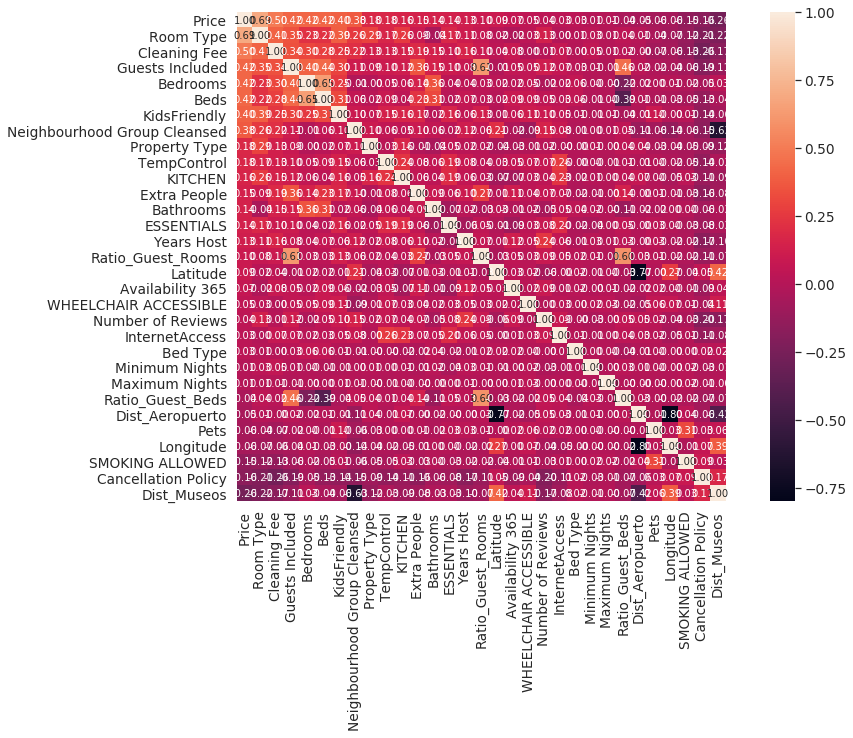

In [0]:
# Matriz de correlación
k = df_train.shape[1] # Número de variables.
corrmat = df_train.corr()
cols = corrmat.nlargest(k,'Price')['Price'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = cols.values, xticklabels = cols.values)
plt.show()

In [0]:
corr = df_train.corr()
corr[['Price']].sort_values(by = 'Price',ascending = False)\
.style.background_gradient()

,Price
Price,1
Room Type,0.691024
Cleaning Fee,0.49862
Guests Included,0.422928
Bedrooms,0.420952
Beds,0.418199
KidsFriendly,0.39828
Neighbourhood Group Cleansed,0.380613
Property Type,0.177786
TempControl,0.175948


Estos gráficos nos muestran que la variable 'Cleaning Fee':

Presenta asimetrías.
Hay un número significativo de observaciones con valor cero (casas sin sótano).
El valor cero no nos permite hacer transformaciones logarítmicas.
Para aplicar una transformación logarítmica, crearé una variable binaria (tener o no tener sótano). Después, aplicaré la transformación logarítmica a todas las observaciones que no sean cero, ignorando aquellas con valor cero. De esta manera podré transformar los datos, sin perder el efecto de tener o no sótano.

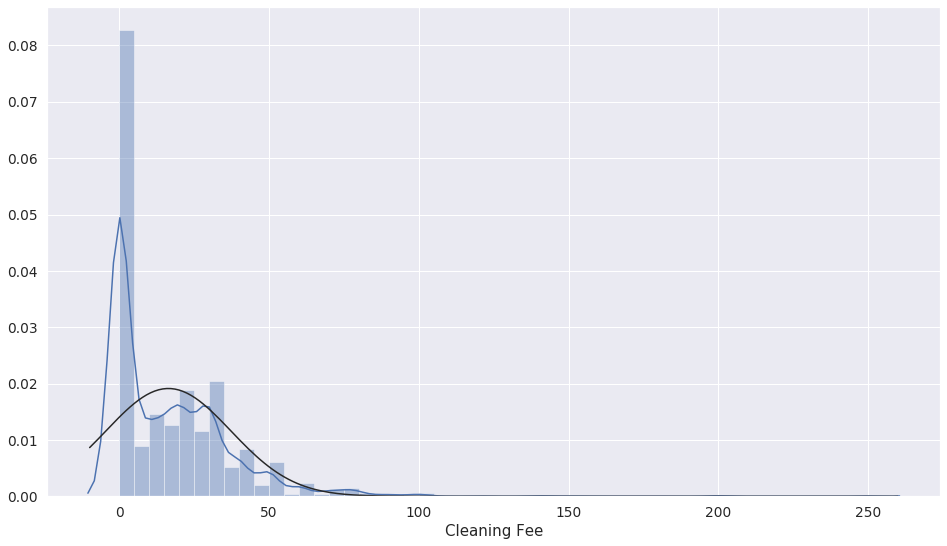

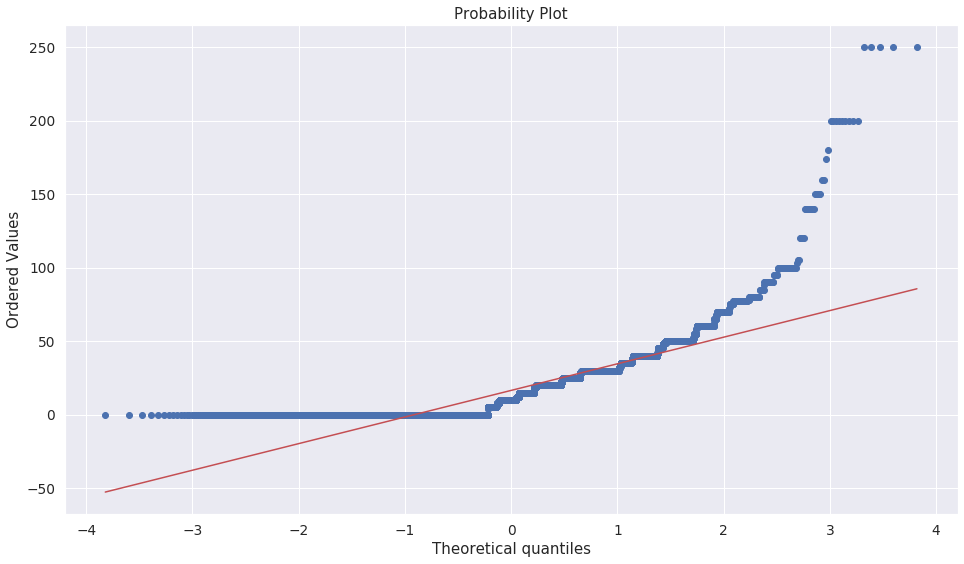

In [0]:
sns.distplot(df_train['Cleaning Fee'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train['Cleaning Fee'], plot = plt)

In [0]:

# Creación de la columna para una nueva variable categórica binaria (1 si area>0, 0 si area==0):

df_train['HasClFee'] = pd.Series(len(df_train['Cleaning Fee']), index = df_train.index)
df_train['HasClFee'] = 0 
df_train.loc[df_train['Cleaning Fee']>0,'HasBsmt'] = 1

# Transformación de datos:

df_train.loc[df_train['HasClFee'] == 1,'Cleaning Fee'] = np.log(df_train['Cleaning Fee'])


In [0]:
df_train = df_train.drop(['HasClFee','HasBsmt'],axis=1)


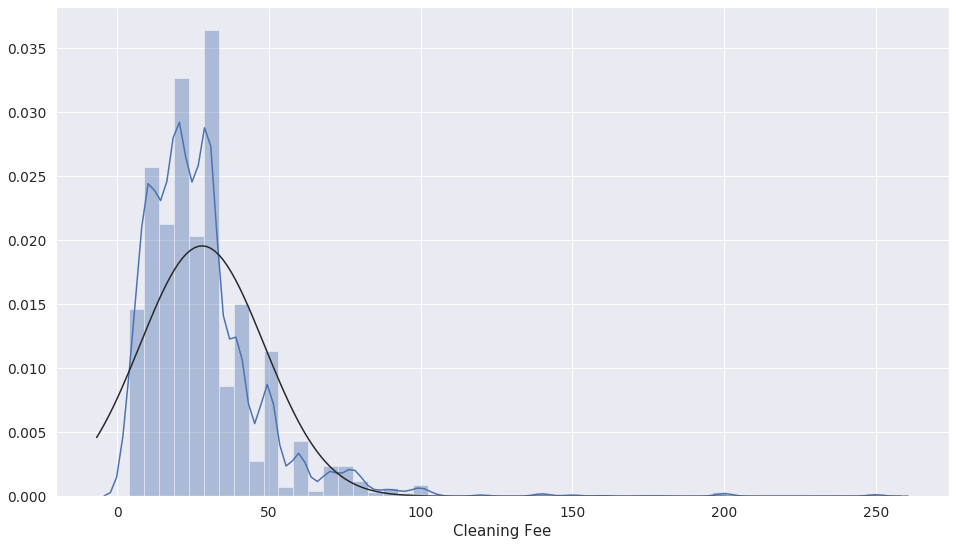

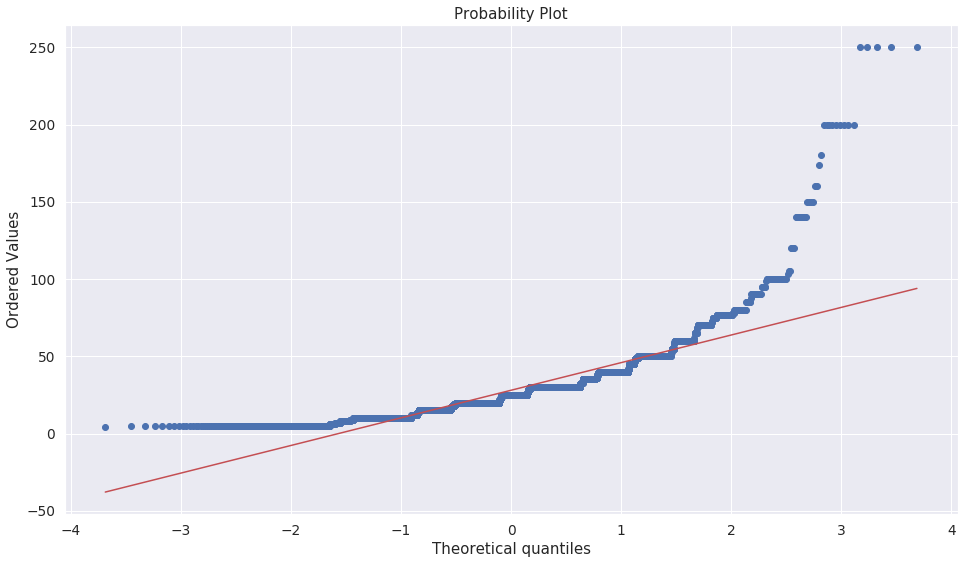

In [0]:
sns.distplot(df_train[df_train['Cleaning Fee'] > 0]['Cleaning Fee'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['Cleaning Fee']>0]['Cleaning Fee'], plot = plt)

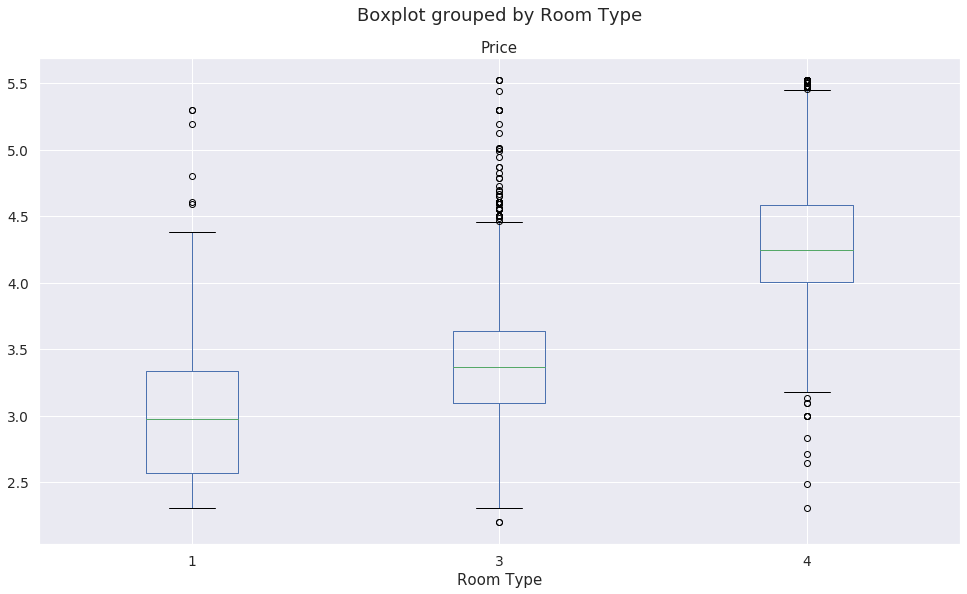

In [0]:
import matplotlib.pyplot as plt

df_train.boxplot(by='Room Type',column = 'Price')
plt.show()

In [0]:
corr = df_train.corr()
corr[['Price']].sort_values(by = 'Price',ascending = False)\
.style.background_gradient()

,Price
Price,1
Room Type,0.691024
Cleaning Fee,0.49862
Guests Included,0.422928
Bedrooms,0.420952
Beds,0.418199
KidsFriendly,0.39828
Neighbourhood Group Cleansed,0.380613
Property Type,0.177786
TempControl,0.175948


In [0]:
df_train.isnull().any()

Price                           False
Neighbourhood Group Cleansed    False
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Bathrooms                       False
Bedrooms                        False
Beds                            False
Bed Type                        False
Cleaning Fee                    False
Guests Included                 False
Extra People                    False
Minimum Nights                  False
Maximum Nights                  False
Availability 365                False
Number of Reviews               False
Cancellation Policy             False
Dist_Museos                     False
Dist_Aeropuerto                 False
Ratio_Guest_Beds                False
Ratio_Guest_Rooms               False
ESSENTIALS                      False
KITCHEN                         False
SMOKING ALLOWED                 False
WHEELCHAIR ACCESSIBLE           False
Pets        

In [0]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.85)
pca.fit(df_train)
print(pca.n_components_ )
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

1
[0.99981809]
[1.01225932e+08]


In [0]:
from sklearn.feature_selection import SelectKBest
X=df_train.drop(['Price'], axis=1)
y=df_train['Price']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['Room Type', 'Bedrooms', 'Beds', 'Cleaning Fee', 'Guests Included'], dtype='object')


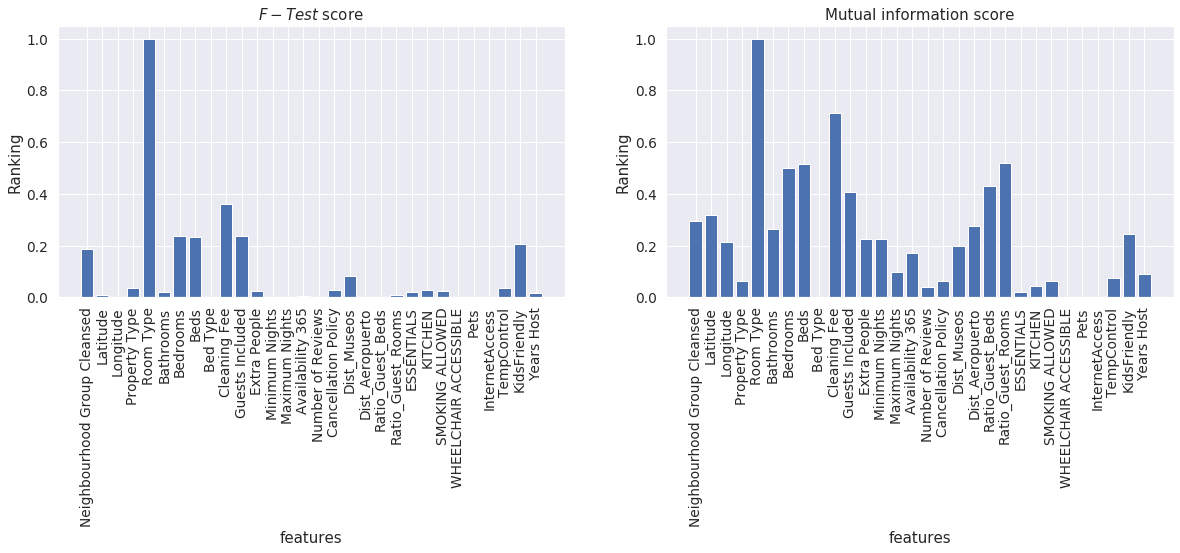

In [0]:
from sklearn.feature_selection import f_regression, mutual_info_regression
# convertimos el DataFrame al formato necesario para scikit-learn
data = df_train.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df_train.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

# 2.- Creación del modelo

In [0]:
dataframe = df_train[:]
print(dataframe.tail(25))
dataframe.fillna(0,inplace=True)
#normalizamos los datos
scaler=StandardScaler()
df = dataframe.drop(['Price'], axis=1) # quito la variable dependiente "Y"
scaler.fit(df) # calculo la media para poder hacer la transformacion
X_scaled=scaler.transform(df)# Ahora si, escalo los datos y los normalizo
 
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=25) # Otra opción es instanciar pca sólo con dimensiones nuevas hasta obtener un mínimo "explicado" ej.: pca=PCA(.85)
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA
 
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:8]))
print(X_pca)
#Vemos que con 5 componentes tenemos algo mas del 85% de varianza explicada
 

In [0]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
 
#graficamos en 2 Dimensiones, tomando los 2 primeros componentes principales
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=dataframe['Price'].values
cdict={0:'red',1:'green'}
labl={0:'Alquilar',1:'Comprar'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],label=labl[l],s=40,marker=marker[l],alpha=alpha[l])
 
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()


In [0]:
# Comprobamos si queda algún campo con valores Nan
nan_rows = df_train[df_train.isnull().any(1)]
nan_rows

In [0]:
df_train.isnull().any()

In [0]:
#cargamos las librerías necesarias para procesar los datos de entrenamiento
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = df_train.values

# Para el y_train nos quedamos con la primera columna (recordar que movimos el precio a la primera posición)
y_train = data[:,0:1] 
#Para los datos nos quedamos con el resto de las columnas
X_train = data[:,1:]      

feature_names = df_train.columns[1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [0]:
# Vamos a hacer una validación cruzada de los datos de entrenamiento con GridSearchCV y Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1.5,-0.5)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 25)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [0]:
#Vamos a cargar los datos de test, y repetimos todos los pasos que hemos dado con los datos de entrenamiento
df_test = pd.read_csv('./data/test.csv', sep=';', decimal='.')
print(df_test.columns)
print(columns_to_drop)

In [0]:
df_test= df_test[df_test['Smart Location'].isin(lista_madrid_0)]

df_test['Dist_Museos']=df_test.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_museos,lon_museos),axis=1)


df_test['Dist_Aeropuerto']=df_test.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_aeropuerto,lon_aeropuerto),axis=1)


df_test['Dist_Atocha']=df_test.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_atocha,lon_atocha),axis=1)


df_test['Dist_Chamartin']=df_test.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_atocha,lon_atocha),axis=1)


df_test['Dist_Aeropuerto']=df_test.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_aeropuerto,lon_aeropuerto),axis=1)

df_test['Cleaning Fee'].fillna(0., inplace=True)
df_test['Dist_Aeropuerto']=df_test.apply(lambda row:haversine(row.Latitude, row.Longitude,lat_aeropuerto,lon_aeropuerto),axis=1)
df_test.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(['Accommodates','Availability 30', 'Availability 60', 'Availability 90','Dist_Atocha','Dist_Chamartin','Dist_Aeropuerto'], axis=1, inplace=True)
df_test=df_test[df_test['Price']<=250]
df_test.drop(df_test[(df_test['Bathrooms'] == 0) & (df_test['Room Type'] =='Entire home/apt')].index,inplace=True)

df_test.fillna(df_test.mean(), inplace=True)
df_test.drop(['Neighbourhood Cleansed'],axis=1,inplace=True)
df_test['Host Since'].dropna(inplace=True) 
df_test['Host Since'] = df_test['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df_test['Years Host'] = df_test['Host Since'].apply(lambda x: 2017 - x.year)
df_test['Years Host'].dropna(inplace=True) 
df_test.drop(['Host Since'], axis=1, inplace=True)
categorical = [ 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy','Neighbourhood Group Cleansed']

#Para categorizar, vamos a usar el diccionrio que creamos al entrenar, para tener categorías equivalentes
for c in categorical:
    df_test[c] = df_test[c].map(mean_map[c])
columns_t = df_test.columns.tolist()
columns_t.insert(0, columns_t.pop(columns_t.index('Price')))
df_test = df_test[columns_t]
print('Dimensión del dataset de test:',df_test.shape)

print('Comprobamos si hay algún valor NaN en el dataset de test')
df_test.isnull().any()

In [0]:
# Comprobamos cuantos nulos tenemos en 'Property Type'
len(df_test)-df_test['Property Type'].count()

In [0]:
# Comprobamos cuantos nulos tenemos en 'Years Host'
len(df_test)-df_test['Years Host'].count()

In [0]:
#Eliminamos los registros con NaN
print('Dimensiones antes de eliminar nulos:',df_test.shape)
df_test.dropna(inplace=True)
print('Dimensiones después de eliminar nulos:',df_test.shape)

In [0]:
#Comprobamos si queda alguna variable sin categorizar
df_test[categorical].dtypes

In [0]:
data_test = df_test.values

y_test = data_test[:,0:1]     
X_test = data_test[:,1:]      

feature_names_test = df_test.columns[1:]

# Vamos a normalizar igual que en el entrenamiento
XtestScaled = scaler.transform(X_test) 

In [0]:
# Aplicamos Lasso y comprobamos cual es el error cuadrático medio
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.5g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.5g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

Usaremos para nuestro modelo GradientBoostingRegressor, pensando que es el algoritmo que nos va a dar mejores resultados.
Ejecutamos en primer lugar el siguiente código.

Lo pongo como texto porque, se pasan tres argumentos, entre los que se incluye max_depth. Esto supone un gran coste computacional (tarda en calcular cerca de las dos horas). Por ello, para no penalizar los cálculos que se hacen con posterioridad, lo pongo como texto. El resultado de su ejecución nos da como valor ótipimo para *max_depth cuatro* 


from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500, 1000, 5000]
learningRate = [0.1, 0.01,0.05]
max_depth = [2,3,4]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate,'max_depth':max_depth }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Este sería el resultado obtenido:
best mean cross-validation score: 0.721
best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [0]:
#repetimos el proceso, dejando fijo el max_depth a cuatro, y cambiando ligeramente los valores de Niterations,
# dado que, en la ejecución anterior nos dio un valor de 500, probamos con un valor inferior

from sklearn.ensemble import GradientBoostingRegressor

Niterations0 = [400,500,1000]
learningRate0 = [0.01,0.05]


param_grid0 = {'n_estimators': Niterations0,'learning_rate':learningRate0 }
grid0 = GridSearchCV(GradientBoostingRegressor(random_state=0,max_depth = 4), param_grid=param_grid0, cv = 5)
grid0.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid0.best_score_))
print("best parameters: {}".format(grid0.best_params_))

In [0]:
#Mostramos el resultado de la ejecución del modelo
lRateOptimo = grid0.best_params_['learning_rate']
nEstimatorsOptimo = grid0.best_params_['n_estimators']


bt0 = GradientBoostingRegressor(random_state=0, max_depth=4,learning_rate=lRateOptimo, n_estimators=nEstimatorsOptimo)
bt0.fit(X_train,y_train)

error = 1-grid0.cv_results_['mean_test_score'].reshape(len(learningRate0),len(Niterations0))

colors = ['r','b','g','k','m']

for i,lr in enumerate(learningRate0): 
    plt.plot(Niterations0,error[i,:],colors[i] + '--o',label='lr = %g '%lr )

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt0.score(X_train,y_train),bt0.score(X_test,y_test)))
plt.grid()
plt.show()

In [0]:
#Hacemos otra prueba a ver si el modelo mejora

Niterations1 = [200,400,500]
learningRate1 = [0.01,0.05]


param_grid1 = {'n_estimators': Niterations1,'learning_rate':learningRate1 }
grid1 = GridSearchCV(GradientBoostingRegressor(random_state=0,max_depth = 4), param_grid=param_grid1, cv = 5)
grid1.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid1.best_score_))
print("best parameters: {}".format(grid1.best_params_))

In [0]:
lRateOptimo1 = grid1.best_params_['learning_rate']
nEstimatorsOptimo1 = grid1.best_params_['n_estimators']


bt1 = GradientBoostingRegressor(random_state=0, max_depth=4,learning_rate=lRateOptimo1, n_estimators=nEstimatorsOptimo1)
bt1.fit(X_train,y_train)

error1 = 1-grid1.cv_results_['mean_test_score'].reshape(len(learningRate1),len(Niterations1))

colors = ['r','b','g','k','m']

for i,lr in enumerate(learningRate1): 
    plt.plot(Niterations1,error1[i,:],colors[i] + '--o',label='lr = %g '%lr )

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt1.score(X_train,y_train),bt1.score(X_test,y_test)))
plt.grid()
plt.show()

In [0]:
# Probamos con max_depth = 3 por si acaso con otros parámetos tenemos valores direrentes
Niterations2 = [200,400,500]
learningRate2 = [0.01,0.05]


param_grid2 = {'n_estimators': Niterations1,'learning_rate':learningRate1 }
grid2 = GridSearchCV(GradientBoostingRegressor(random_state=0,max_depth = 3), param_grid=param_grid2, cv = 5)
grid2.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid1.best_score_))
print("best parameters: {}".format(grid1.best_params_))

In [0]:



bt2 = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=0.05, n_estimators=500)
bt2.fit(X_train,y_train)

error2 = 1-grid2.cv_results_['mean_test_score'].reshape(len(learningRate1),len(Niterations1))

colors = ['r','b','g','k','m']

for i,lr in enumerate(learningRate1): 
    plt.plot(Niterations1,error2[i,:],colors[i] + '--o',label='lr = %g '%lr )

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt2.score(X_train,y_train),bt2.score(X_test,y_test)))
plt.grid()
plt.show()

Los resultados empeoran, así que nos quedarmos con los parámetros del caso anterior, que da mejor resultado y este es bastante aceptable, aunque sería deseable una menor diferencia entre los resultados de train y test

Creamos un gráfico que muestre qué importancia se da a los datos que se han usado para crear el modelo

In [0]:
importances = bt1.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14,14))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])

plt.show()

No creo  que sorprenda que el dato más importante es sea el tipo de habitación,
seguido  de baños y camas (yo probablemente hubiera esperado el resultado al revés).

También es muy razonable que el barrio tenga un peso prácticamente equivalente a la distancia a los Museos.

A mi particularmente me sorprenden las posiciones ocupadas por la tasa de limpieza y la disponibilidad 365
(más altas de lo esperable), así como el tipo de propiedad (mucho más bajo de lo que yo preveía).
